In [1]:
from atmPy.aerosols.physics import hygroscopicity as hyg
from atmPy.data_archives import arm
from atmPy.aerosols.size_distribution import sizedistribution
%matplotlib inline

# HygroscopicGrowthFactorDistributions

We need to generate a data set that can be used to initiate a HygroscopicGrowthFactorDistributions instance. Hiere we take Arm data generated by a HTDMA. The Arm data contains gf-distributions for different diameters, so we select one (200.0 nm).

In [2]:
fname = '../atmPy/unit_testing/test_data/sgptdmahygC1.b1.20120601.004227.cdf'
out = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)

# in general

Peaks in the gf-distribution are detected and fit by normal distributions (at log-base). Fit parameters are tightly constrained to avoid run-away parameters and unrealistic results, which in turn can result in unexpacted results ... hard coded fit parameters/boundaries might need adjustment.

# Growth modes

Position of detected growthmodes and ratio of particles in it as a function of time. Here plotted on top of the gf-distribution time series.

(<matplotlib.figure.Figure at 0x1164f6278>,
 None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


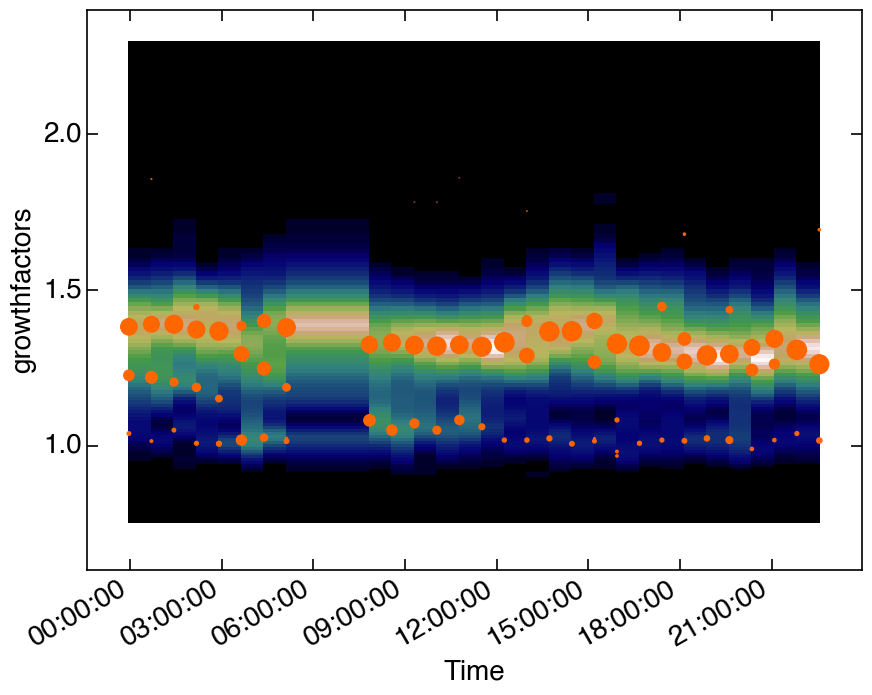

In [7]:
out.hyg_distributions_d200nm.plot(growth_modes=True)

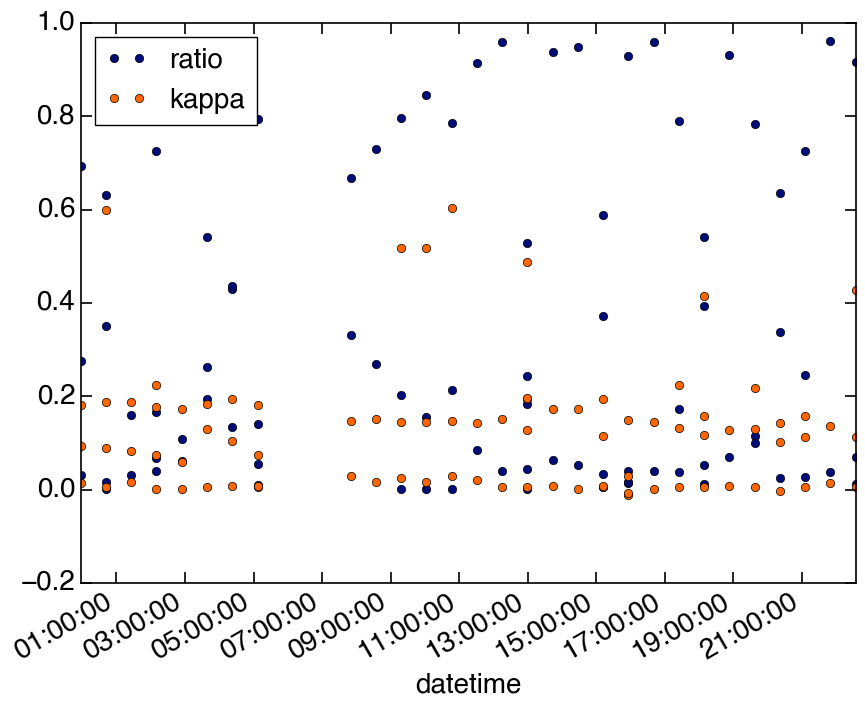

In [11]:
out.hyg_distributions_d200nm.growth_modes_kappa.plot(ls = '', marker = 'o')

# Mixing state

I came up with the following definition, it should be adjusted if there is a better one in the literature
 
Mixing state is given by the pythagoras of the particle ratios of all detected growth modes in a growth distribution. E.g. if there where three modes detected with ratios $r_1$, $r_2$, $r_3$ the mixing state is given by $\sqrt{r_1^2 + r_2^2 + r_3^2}$.

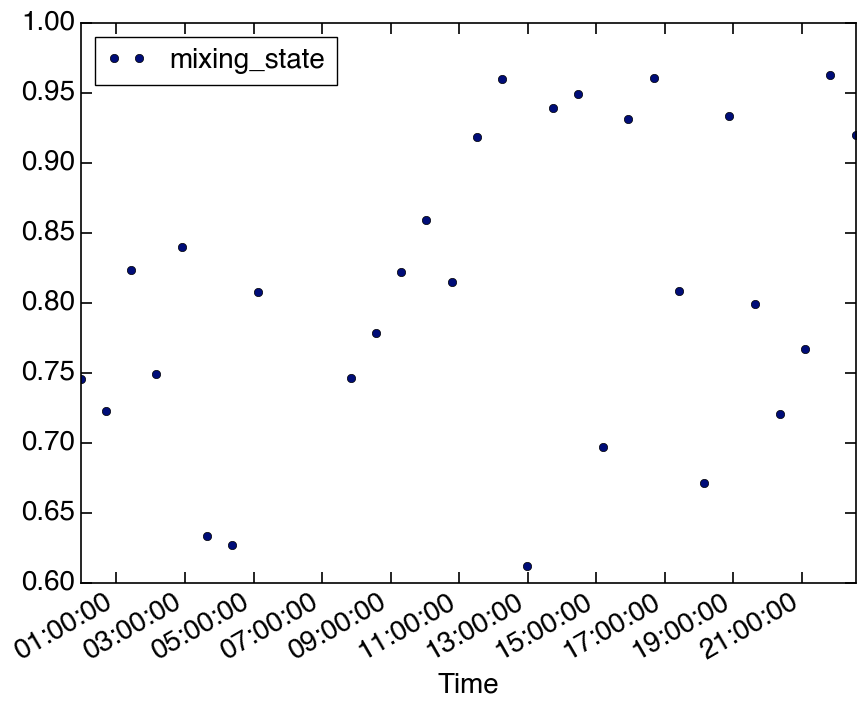

In [8]:
out.hyg_distributions_d200nm.mixing_state.plot(marker = 'o', ls = '')

# Applied to sizedistribution ... grow accordingly

In [6]:
hgfd = out.hyg_distributions_d200nm

(<matplotlib.figure.Figure at 0x1081ab2e8>,
 None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


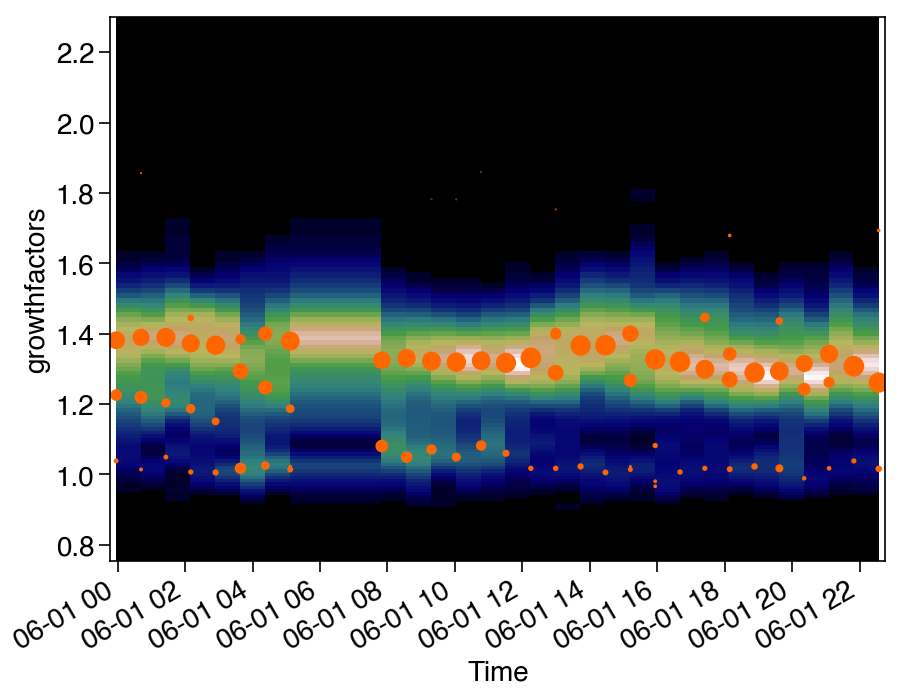

In [7]:
hgfd.plot(growth_modes=True)

In [8]:
gmk = out.hyg_distributions_d200nm.growth_modes_kappa

(<matplotlib.figure.Figure at 0x10bf5edd8>,
 <matplotlib.colorbar.Colorbar at 0x111638908>)

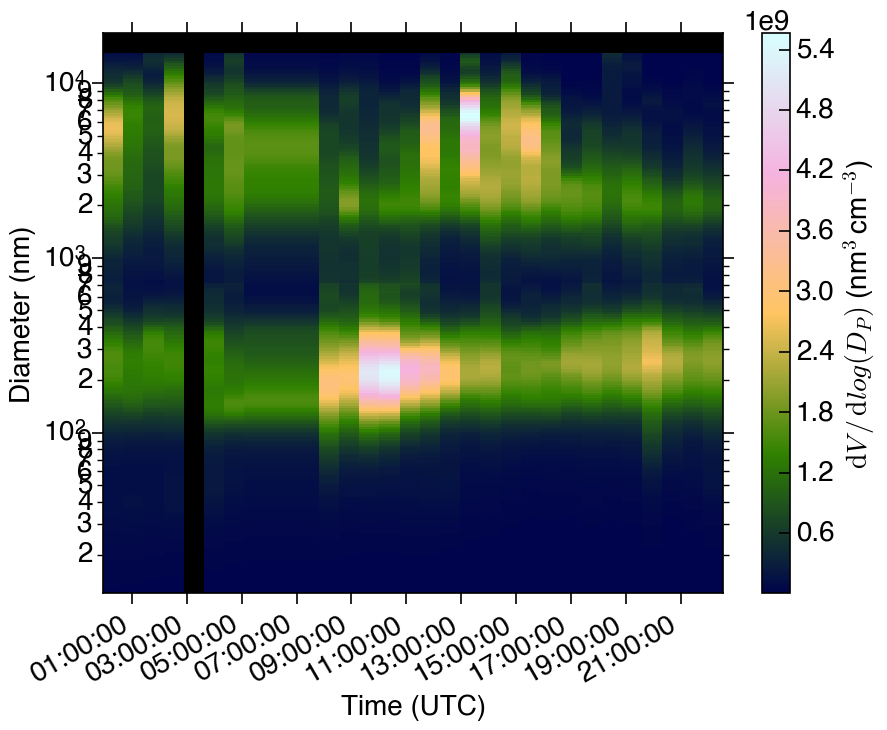

In [4]:
sd.convert2dVdlogDp().plot()

(<matplotlib.figure.Figure at 0x10a2cbcc0>,
 <matplotlib.colorbar.Colorbar at 0x10ec064e0>)

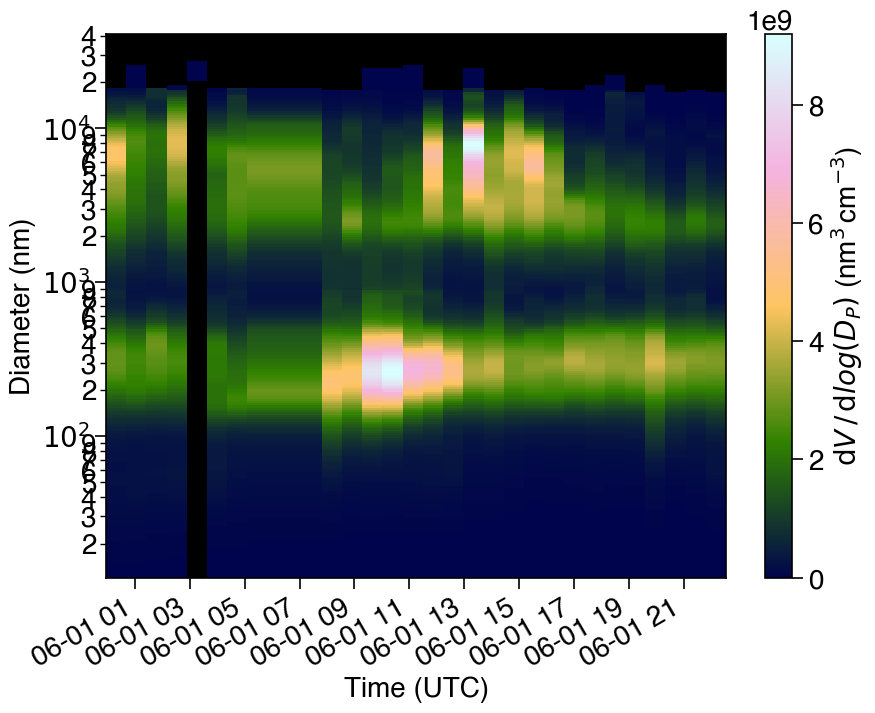

In [19]:
sdtsout.convert2dVdlogDp().plot()

In [104]:
sd.optical_properties.parameters.wavelength = 550
sd.optical_properties.parameters.refractive_index = 1.5
RH_high = 85.

In [105]:
def apply_growth_distribution(sd, growth_dist, RH):
    """Apply hygroscopic growth on dry sizedistribution (sd) by applying a growth distribution (growth_dist).
    Parameters
    ----------
    sd: sizedist_TS instance
    growth_dist: growth_distribution instance
    RH: float
        Relative humidity at which the grown sizedistribution is supposed to calculated"""
    gmk = growth_dist.growth_modes_kappa
    sdtsumlist = []
    sd_growth_res = {}
    for u,i in enumerate(gmk.index.unique()):
        # get sizedist and kappa for the particular time ... kappa contains likely multiple values
        gmkt = gmk.loc[i,:]
        sdd = sd.data.loc[i,:]

        # make a size distribution from the particular slice
        sdsd = sizedistribution.SizeDist_TS(pd.DataFrame(sdd).transpose(), sd.bins, sd.distributionType)
        sdsd.hygroscopicity.parameters.refractive_index = sd.parameters4reductions.refractive_index
        sdsd.hygroscopicity.parameters.RH = RH_high
        datasum = None
        sd_growth_res_dict = {}
        sd_growth_dict_list = [] 
        for e, (_,gm) in enumerate(gmkt.iterrows()):
            sd_growth_dict = {}
            sdt = sdsd.copy()
            sdt.data *= gm.ratio
            if gm.kappa < 0:
                kappa = 0.0001 #in principle this is a bug ... does not like kappa == 0
            else:
                kappa = gm.kappa

            sdt.hygroscopicity.parameters.kappa = kappa
            sdtg = sdt.hygroscopicity.grown_size_distribution

            sd_growth_dict['kappa'] = kappa
            sd_growth_dict['size_dist_grown'] = sdtg

            ###### 
            # in order to be able merge size distributions we have to find the biggest bins
            if e == 0:
                datasum = sdtg.data
                lastbin = sdtg.bins[-1]
                bins = sdtg.bins.copy()
                tbins = sdtg.bins.copy()
            else:
                if sdtg.bins[-1] > lastbin:
                    lastbin = sdtg.bins[-1]
                    bins = sdtg.bins.copy()
                lbins = sdtg.bins.copy()
                datasum = datasum.add(sdtg.data, fill_value = 0)

            #####
            # add dict to list
            sd_growth_dict_list.append(sd_growth_dict)


        sdtsum = sizedistribution.SizeDist(datasum, bins, sdtg.distributionType)
        sdtsumlist.append(sdtsum)
        sd_growth_res_dict['index'] = i
        sd_growth_res_dict['individual'] = sd_growth_dict_list
        sd_growth_res_dict['sum'] = sdtsum
        if u == 0:
            sdtsumall = sdtsum.data
            binsall = bins.copy()
            lastbinall = bins[-1]
        else:
            if bins[-1] > lastbinall:
                binsall = bins.copy()
                lastbinall = bins[-1]
            sdtsumall = sdtsumall.add(sdtsum.data, fill_value = 0)
        ## enter into res dictionary
        sd_growth_res[i] = sd_growth_res_dict
    #     if u == 19:
    #         break


    sdtsout = sizedistribution.SizeDist_TS(sdtsumall, binsall,  sdtg.distributionType)
    out = {}
    out['grown_size_dists_sum'] = sdtsout
    out['grown_size_dists_individual']  = sd_growth_res
    return out

# apply otical properties

## single grown sizedist

In [106]:
sdgt = sd_growth_res[list(sd_growth_res.keys())[0]]['individual'][0]['size_dist_grown']

In [108]:
for a, index in enumerate(sd_growth_res.keys()):
    # for e,indi in enumerate(sd_growth_res[list(sd_growth_res.keys())[0]]['individual']):
    for e,indi in enumerate(sd_growth_res[index]['individual']):
        sdgt = indi['size_dist_grown']
    #     print(indi['kappa'])

        sdgt.optical_properties.parameters.wavelength = sd.optical_properties.parameters.wavelength
    #     print(sdgt.optical_properties.scattering_coeff)

        if e == 0:
            scattering_coeff = sdgt.optical_properties.scattering_coeff.data.copy()
        else:
            scattering_coeff += sdgt.optical_properties.scattering_coeff.data
    if a == 0:
        scattering_coeff_ts = scattering_coeff.copy()
    
    else:
        scattering_coeff_ts = pd.concat([scattering_coeff_ts,scattering_coeff])
        
#     if a==1:
#         break

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


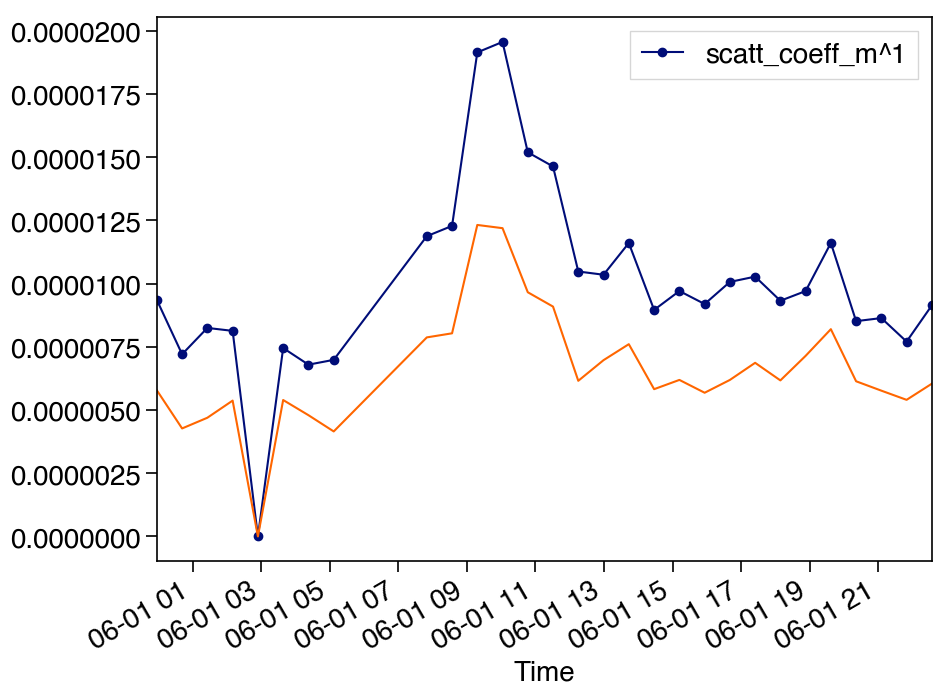

In [109]:
a = scattering_coeff_ts.plot(marker = 'o')
sd.optical_properties.scattering_coeff.plot(ax = a)

In [26]:
avgout = sdtsout.average_overAllTime()
avgsd = sd.average_overAllTime()

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


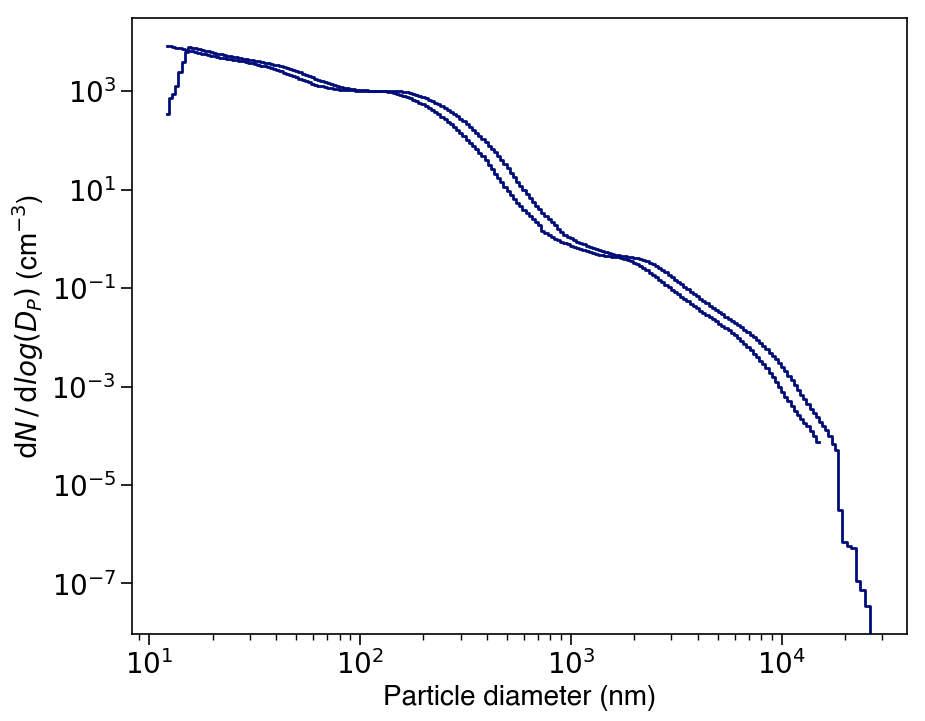

In [50]:
f,a = avgout.convert2dNdlogDp().plot()
avgsd.convert2dNdlogDp().plot(ax = a)
a.set_yscale('log')
# a.set_xscale('linear')

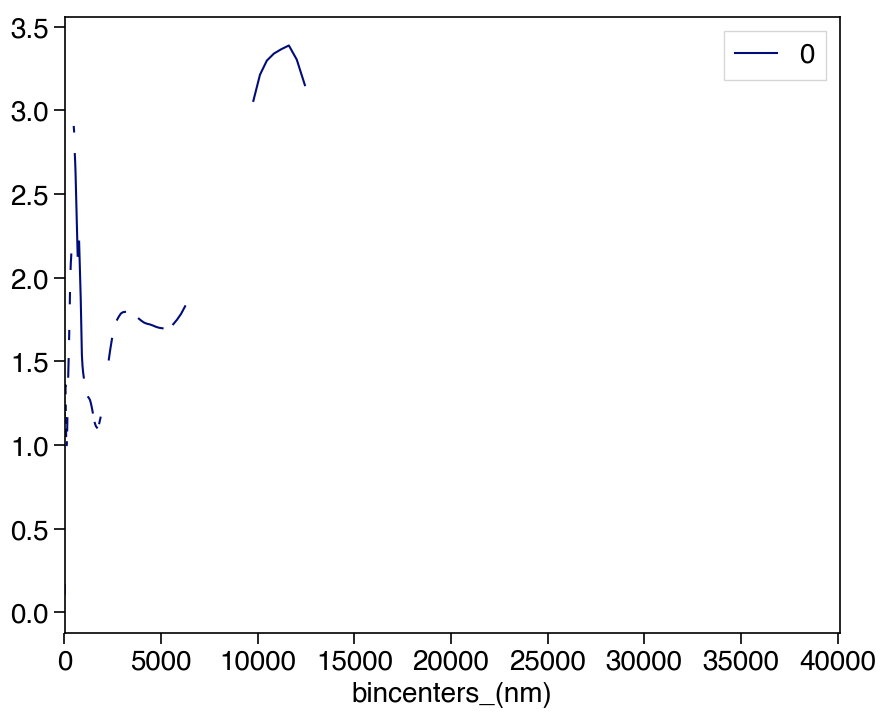

In [49]:
# a = avgout.convert2dNdlogDp().data.transpose().plot()
# avgsd.convert2dNdlogDp().data.transpose().plot(ax = a)

quz = avgout.convert2dNdlogDp().data.transpose() / (avgsd.convert2dNdlogDp().data.transpose())
quz.plot()
# a.set_yscale('log')
# a.set_xscale('linear')

(<matplotlib.figure.Figure at 0x10ecc3dd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fbbd7f0>)

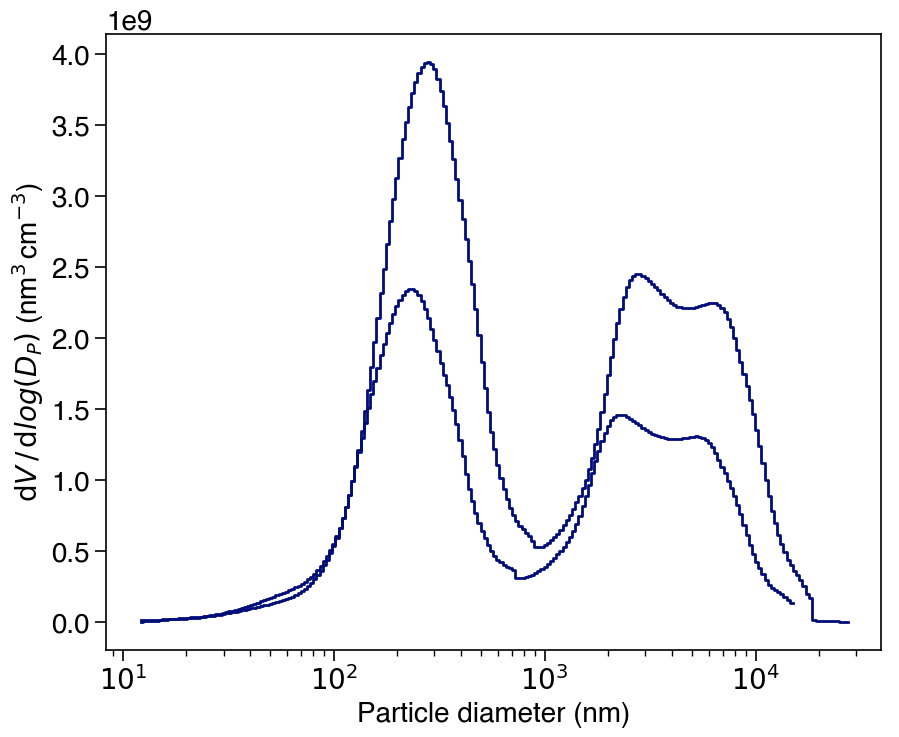

In [31]:
f,a = avgout.convert2dVdlogDp().plot()
avgsd.convert2dVdlogDp().plot(ax = a)

In [136]:
buba = sdtsumlist[0].data.add(sdtsumlist[1].data, fill_value = 0)
buba

bincenters_(nm),12.2100000381,12.6425004005,13.0850000381,13.5424995422,14.0149998665,14.5050001144,15.0149998665,15.5424995422,16.0875005722,16.6525011063,...,25480.7297233,26797.536562,28182.3940518,29638.8189509,31170.5097584,32781.3561062,34475.4486369,36257.0893914,38130.8027339,40101.3468411
Time,,,,,,,,,,,,,,,,,,,,,
2012-05-31 23:57:27,3.276410,10.436931,10.085576,89.772446,96.52143,93.697059,125.702193,311.668199,301.486579,291.09280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-01 00:41:39,3.751712,4.845282,4.696229,6.510068,106.25421,103.498564,103.451035,283.720404,280.564838,271.86429,...,2.256461e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
sdtsumlist[0].data

bincenters_(nm),12.2100000381,12.6425004005,13.0850000381,13.5424995422,14.0149998665,14.5050001144,15.0149998665,15.5424995422,16.0875005722,16.6525011063,...,18176.5556641,18898.4150391,19806.0,20829.5424938,21905.9871551,23038.056527,24228.6295881,25480.7297233,26797.536562,28182.3940518
Time,,,,,,,,,,,,,,,,,,,,,
2012-05-31 23:57:27,3.27641,10.436931,10.085576,89.772446,96.52143,93.697059,125.702193,311.668199,301.486579,291.0928,...,9.920568e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


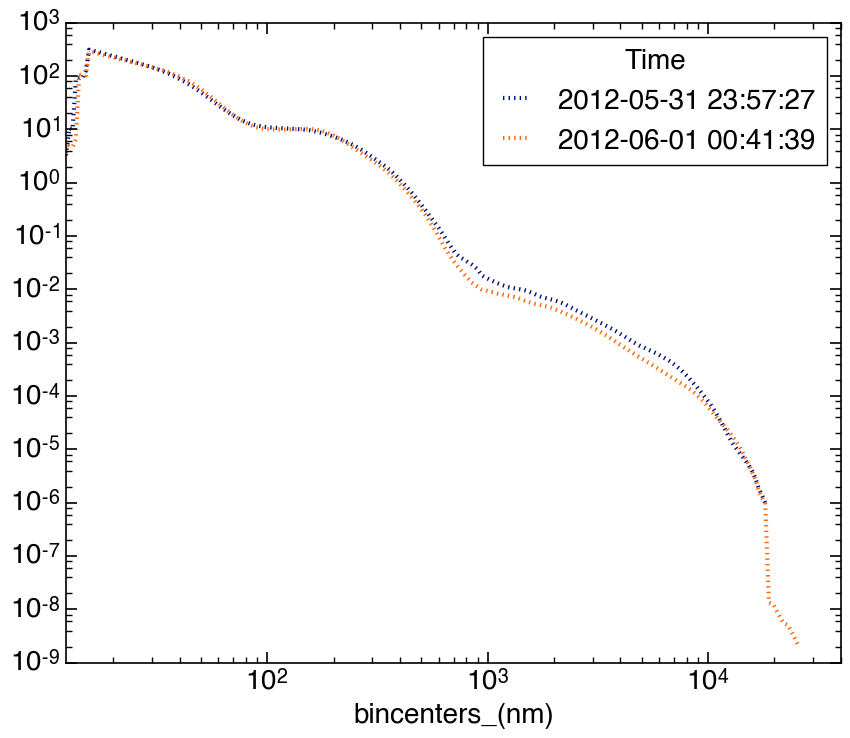

In [135]:
f,a = plt.subplots()
# for sdbla in sdtsumlist:
#     sdbla.plot(ax = a)
a.loglog()
buba.transpose().plot(ax = a, lw = 3, ls = ':')

In [86]:
sdsd = sizedistribution.SizeDist_TS(pd.DataFrame(sdd).transpose(), sd.bins, sd.distributionType)
sdsd.hygroscopicity.parameters.refractive_index = 1.5
sdsd.hygroscopicity.parameters.RH = 85.

In [117]:
# f,a = plt.subplots()
for e, (_,gm) in enumerate(gmkt.iterrows()):
    sdt = sdsd.copy()
    sdt.data *= gm.ratio
    sdt.hygroscopicity.parameters.kappa = gm.kappa
    sdtg = sdt.hygroscopicity.grown_size_distribution
    if e == 0:
        datasum = sdtg.data
    else:
        datasum = datasum.add(sdtg.data, fill_value = 0)
sdtsum = sizedistribution.SizeDist(datasum, sdtg.bins, sdtg.distributionType)

0.0323320366045
0.274846728495
0.692821234901


In [53]:
sd.hygroscopicity.parameters.refractive_index = 1.5
sd.hygroscopicity.parameters.RH = 85.
sdts_grown = []
for e, (_,gm) in enumerate(gmkt.iterrows()):
    sdt = sd.copy()
    sdt.data *= gm.ratio
    sdt.hygroscopicity.parameters.kappa = gm.kappa
#     sdts_grown.append(sdt.hygroscopicity.grown_size_distribution)
    if e == 0:
        datasum = sdt.hygroscopicity.grown_size_distribution.data
    else:
        datasum = datasum.add(sdt.hygroscopicity.grown_size_distribution.data, fill_value = 0)
#     break

In [27]:
sg0 = sdts_grown[0]
sg1 = sdts_grown[1]
sg2 = sdts_grown[2]

In [15]:
from atmPy.aerosols.size_distribution import sizedistribution

In [82]:
sdo = sizedistribution.SizeDist(pd.DataFrame(sd.data.iloc[0,:]).transpose(), sd.bins, sd.distributionType)
sdsdsd = sizedistribution.SizeDist(pd.DataFrame(sdsd.data.iloc[0,:]).transpose(), sdsd.bins, sdsd.distributionType)

In [79]:
sd0 = sizedistribution.SizeDist(pd.DataFrame(sg0.data.iloc[0,:]).transpose(), sg0.bins, sg0.distributionType)
sd1 = sizedistribution.SizeDist(pd.DataFrame(sg1.data.iloc[0,:]).transpose(), sg1.bins, sg1.distributionType)
sd2 = sizedistribution.SizeDist(pd.DataFrame(sg2.data.iloc[0,:]).transpose(), sg2.bins, sg2.distributionType)

In [67]:
datasum = sd0.data + sd1.data + sd2.data
datasum = sd0.data.add(sd1.data, fill_value = 0)
datasum = datasum.add(sd2.data, fill_value = 0)
sdsum = sizedistribution.SizeDist(datasum, sd2.bins, sd0.distributionType)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


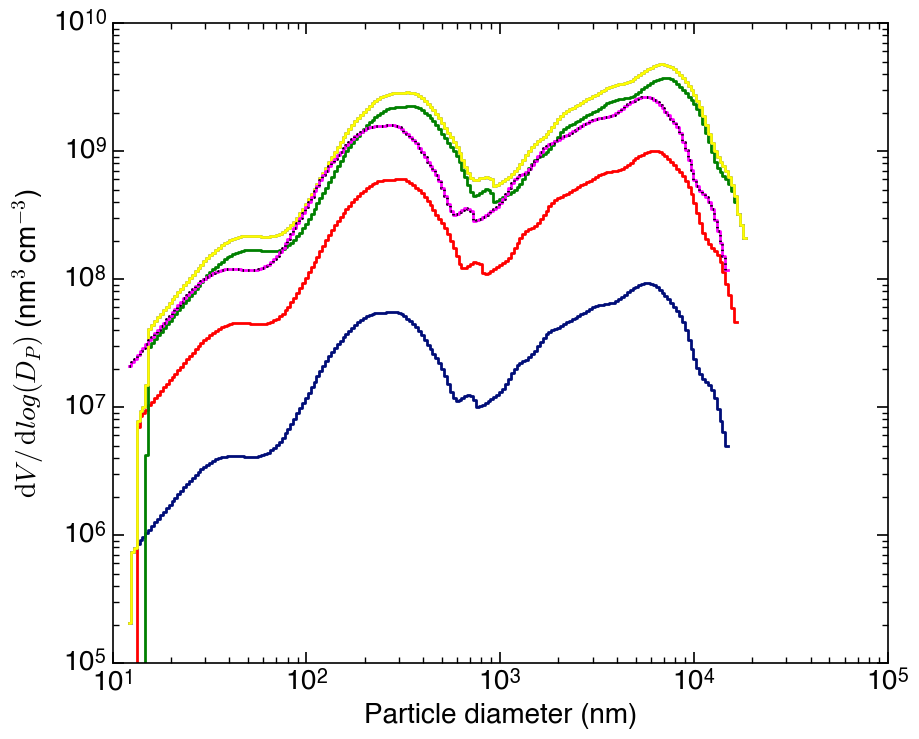

In [119]:
f,a = sd0.convert2dVdlogDp().plot()
sd1.convert2dVdlogDp().plot(ax = a)
g = a.get_lines()[-1]
g.set_color('r')

sd2.convert2dVdlogDp().plot(ax = a)
g = a.get_lines()[-1]
g.set_color('g')

sdsum.convert2dVdlogDp().plot(ax = a)
g = a.get_lines()[-1]
g.set_color('b')

sdtsum.convert2dVdlogDp().plot(ax = a)
g = a.get_lines()[-1]
g.set_color('yellow')

sdo.convert2dVdlogDp().plot(ax = a)
g = a.get_lines()[-1]
g.set_color('magenta')

sdsdsd.convert2dVdlogDp().plot(ax = a)
g = a.get_lines()[-1]
g.set_color('black')
g.set_linestyle(':')

a.set_yscale('log')

In [40]:
sd2.bins[210:]

array([ 16673.74023438,  17258.32421875,  17863.40625   ,  18489.70507812,
        19307.125     ,  20304.875     ,  21354.20998763,  22457.76432265,
        23618.34873142,  24838.91044472,  26122.54900191,  27472.52412202,
        28892.26398158])